# Libraries

In [6]:
import os
import pandas as pd
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import tukey_hsd
import matplotlib.pyplot as plt
import pingouin as pg
from pingouin import ancova
from matplotlib.patches import Patch
#import statannotations as sa
from statannotations.Annotator import Annotator
from statannot import add_stat_annotation
import xlsxwriter
import lxml

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

from datetime import datetime
from scipy.signal import correlate

# Directories


In [7]:
ROOT = Path().resolve().parent      # one level up from current dir
visual_stimulation_df = pd.read_excel(ROOT / "data/Visual_stimulation/flicker_results.xlsx")
visual_stimulation_timecourse_df = pd.read_csv(ROOT / "data/Visual_stimulation/all_timeseries.csv")

# Edit the RC file

In [8]:
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "svg.fonttype": "none"
})

# Set Tick size

In [9]:
sns.set(rc={'axes.linewidth': 2.0})
sns.set_style("white")
sns.set_style("ticks")

# Prep the dataframes

In [10]:
flicker = visual_stimulation_df

# Mock visual stimulation curve

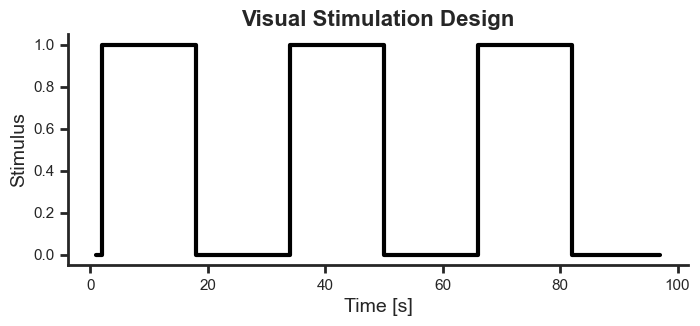

In [11]:
# Parameters
time_stim = 16  # Duration of stimulation in seconds
time_no_stim = 16  # Duration of no stimulation in seconds
repeats = 3  # Number of repetitions

# Generate data
time_points = np.arange(1, (time_stim + time_no_stim) * repeats + 1)
data = np.tile(np.repeat([1, 0], [time_stim, time_no_stim]), repeats)

# Add an initial 0 to the first stimulation
data = np.insert(data, 0, 0)

# Adjust time_points to match the new length of data
time_points = np.arange(1, len(data) + 1)

# Create a DataFrame
stim_data = pd.DataFrame({"Time [s]": time_points, "Stimulation": data})

# Plot the data
fig, ax = plt.subplots(figsize=(8, 3))

sns.lineplot(data=stim_data, x="Time [s]", y="Stimulation", drawstyle='steps-post', color='black', linewidth=3, ax=ax)

plt.title("Visual Stimulation Design", fontsize=16, weight='bold')
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Stimulus", fontsize=14)

ax.tick_params(axis='x', which='both', direction='out', width=2)
ax.tick_params(axis='y', which='both', direction='out', width=2)

for spine in ax.spines.values():
    spine.set_linewidth(2)

sns.despine()
plt.show()

# Save the figure -------
#image_path = os.path.join(outDir, f'Visual_Stimulation_Curve.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, f'Visual_Stimulation_Curve.svg')
#fig.savefig(image_path_svg)

# Panel 2C

        subID  occipital_gm_derivative_tc_1  occipital_gm_derivative_tc_2  \
0    sub-01-1                    -40.353397                    -37.448182   
1    sub-02-1                      8.034841                      9.149008   
2    sub-03-1                    -14.971869                    -12.667442   
3    sub-04-1                    -16.685396                    -15.258976   
4    sub-05-1                     -3.710792                     -4.688563   
..        ...                           ...                           ...   
101  sub-07-9                     -7.389871                      2.753097   
102  sub-08-9                     55.450495                     46.620877   
103  sub-09-9                     24.548691                     19.590570   
104  sub-10-9                    -20.065174                    -18.810298   
105  sub-11-9                      0.560084                      0.748952   

     occipital_gm_derivative_tc_3  occipital_gm_derivative_tc_4  \
0       

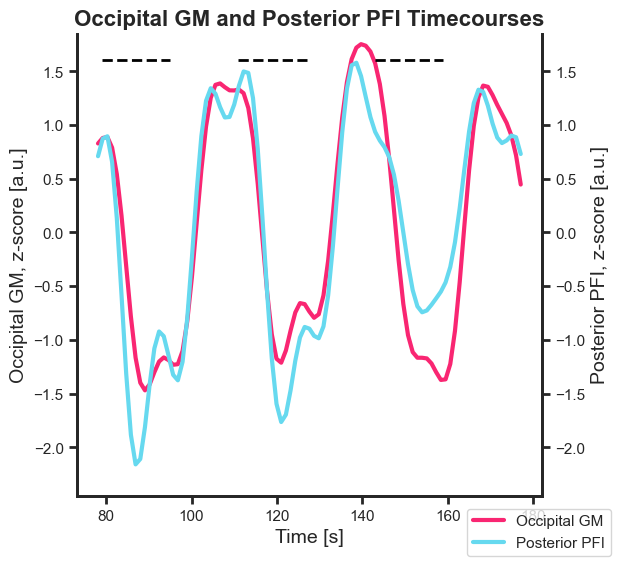

In [12]:

# Read the excel file into a dataframe
flicker_timecourse = visual_stimulation_timecourse_df

print(flicker_timecourse)


# Extract columns
occipital_columns = [col for col in flicker_timecourse.columns if col.startswith('occipital_gm_tc_')]
posterior_columns = [col for col in flicker_timecourse.columns if col.startswith('posterior_pfi_tc')]


# Create a new DataFrame for the reshaped timecourses
Subject = pd.DataFrame()

# Specify the index of the subject you are interested in
subject_row = flicker_timecourse[flicker_timecourse['subID'] == 'sub-15-1']
subject_index = subject_row.index[0]  # Change this to the specific row index of your subject

# Extract the timecourses for the specific subject
timecourses_occipital = flicker_timecourse.loc[subject_index, occipital_columns].values.tolist()
timecourses_occipital = stats.zscore(timecourses_occipital)
timecourses_occipital = -timecourses_occipital
timecourses_occipital_df = pd.DataFrame({'tc': timecourses_occipital})


# Extract the timecourses for the specific subject
timecourses_posterior = flicker_timecourse.loc[subject_index, posterior_columns].values.tolist()
timecourses_posterior = stats.zscore(timecourses_posterior)
timecourses_posterior_df = pd.DataFrame({'tc': timecourses_posterior})

# Generate the ranges
range_occipital = range(1, len(timecourses_occipital) + 1)
range_posterior = range(1, len(timecourses_posterior) + 1)

# Convert ranges to Series for concatenation
range_occipital_series = pd.Series(range_occipital)
range_posterior_series = pd.Series(range_posterior)

# Create a new DataFrame with a single column for the specific subject's timecourses
Subject['tc'] = pd.concat([timecourses_occipital_df, timecourses_posterior_df], axis=0).reset_index(drop=True)
Subject['timepoints'] = pd.concat([range_occipital_series, range_posterior_series], axis=0).reset_index(drop=True)
Subject['timepoints'] = (Subject['timepoints'] * 1.1) + 5 * 1.1 # See if I need to do this!
Subject_categorical = [0] * len(timecourses_occipital_df) + [1] * len(timecourses_posterior_df)  
Subject['variables_categorical'] = Subject_categorical
Subject['Parameters'] = Subject['variables_categorical'].apply(lambda x: "occipital GM" if x == 0 else "posterior PFI")

# Display the new DataFrame
#print(Subject)
Subject_short = Subject[(Subject['timepoints'] >= 78) & (Subject['timepoints'] <= 178)]


fig,ax1 = plt.subplots(figsize=(6, 6)) # was 16,8 for Figure 1
ax2 = ax1.twinx()  # Create secondary y-axis

sns.lineplot(x="timepoints", y='tc', data=Subject_short[Subject_short['Parameters'] == "occipital GM"], ax=ax1, label='Occipital GM', color=(249/255, 38/255, 114/255), linewidth=3, legend=False)
sns.lineplot(x="timepoints", y='tc', data=Subject_short[Subject_short['Parameters'] == "posterior PFI"], ax=ax2, label='Posterior PFI', color=(102/255, 217/255, 239/255), linewidth=3, legend=False)

# Flip ax1 values
#ax1.set_ylim(ax1.get_ylim()[::-1])

# Set labels
ax1.set_xlabel('Time [s]', fontsize=14)
ax1.set_ylabel('Occipital GM, z-score [a.u.]', fontsize=14)
ax2.set_ylabel('Posterior PFI, z-score [a.u.]', fontsize=14)

# Adjust ticks
ax1.tick_params(axis='y')
ax1.set_ylim(-2.45,1.85)
ax2.set_ylim(-2.45,1.85)
ax2.tick_params(axis='y')

# Title and legend
plt.title('Occipital GM and Posterior PFI Timecourses', fontsize=16, weight='bold')

# Add horizontal lines
highlight_y = 1.6  # Choose a y-position that doesn't overlap key data

for start_time in [79, 111, 143]:
    ax1.hlines(y=highlight_y, xmin=start_time, xmax=start_time + 16, 
               colors='black', linestyles='dashed', linewidth=2)


# Remove legends

fig.legend(loc='lower right')
sns.despine(right=False, left=False)

#ax1.legend(title='')
ax1.tick_params(axis='x', which='both', direction='out', width=2)
ax1.tick_params(axis='y', which='both', direction='out', width=2)
ax2.tick_params(axis='x', which='both', direction='out', width=2)
ax2.tick_params(axis='y', which='both', direction='out', width=2)


# Save the figure -------
#image_path = os.path.join(outDir, f'Flicker_timecourse_Sub-15-1.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Flicker_timecourse_Sub-15-1.svg')
#fig.savefig(image_path_svg, transparent=True)


# Panel 2D left

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
-1.1
-0.5669581442597025


Text(0.6, 0.2, 'Rmin lag = -1.1s')

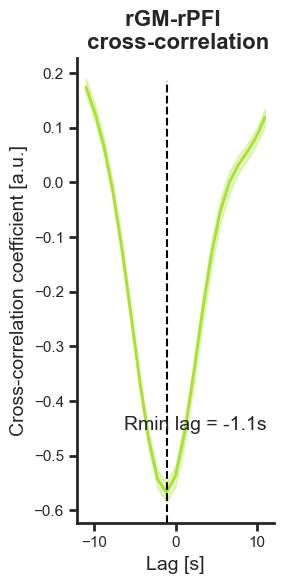

In [13]:
# Extract lag numbers from column names
lag_numbers = [int(col.split('_')[-1]) for col in flicker.columns if col.startswith('xcorr_posterior_ventricle_occipital_gm_')]
lag_numbers.sort()  # Sort lag numbers in ascending order
print(lag_numbers)
# Calculate mean and standard error of the mean (SEM) across all subjects for each time lag
mean_values = flicker[[f'xcorr_posterior_ventricle_occipital_gm_{lag}' for lag in lag_numbers]].mean(axis=0)
sem_values = flicker[[f'xcorr_posterior_ventricle_occipital_gm_{lag}' for lag in lag_numbers]].sem(axis=0)

# Convert to arrays for plotting
time_lags = lag_numbers
time_lags_plot = np.arange(-10, 11)
time_lags_plot = time_lags_plot * 1.1
mean_values_array = mean_values.values
sem_values_array = sem_values.values

max_y_index = np.argmin(mean_values_array)
max_y = mean_values_array[max_y_index]
max_x = time_lags_plot[max_y_index]

print(max_x)

fig = plt.figure(figsize=(3, 6))

# Plot the mean line with error bars
xcorr_mean = sns.lineplot(x=time_lags_plot, y=mean_values_array, color=(166/255, 226/255, 46/255), linewidth=2)
xcorr_mean.fill_between(time_lags_plot,mean_values_array-sem_values_array,mean_values_array+sem_values_array, color=(166/255, 226/255, 46/255), alpha=0.3)
xcorr_mean.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
xcorr_mean.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed

# Annotate the maximum value with its x and y values
#axes[0].annotate(f'Min: ({max_x:.2f}, {max_y:.2f})', xy=(max_x, max_y), xytext=(max_x + 1, max_y), arrowprops=dict(facecolor='black', arrowstyle='->'))
xcorr_mean.axvline(x=max_x, linestyle='--', color='black', linewidth=1.5, ymax=0.95)
print(max_y)
plt.title(f'rGM-rPFI \n cross-correlation',fontsize = 16,weight='bold', loc='center')
plt.xlabel('Lag [s]', fontsize = 14)
plt.ylabel('Cross-correlation coefficient [a.u.]', fontsize = 14)
plt.tight_layout()
sns.despine()

plt.text(0.6, 0.2, f"Rmin lag = {max_x:.1f}s", fontsize=14, ha='center', transform=plt.gca().transAxes)

# Save the figure -------
#image_path = os.path.join(outDir, f'Flicker_cross_corr_1.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Flicker_cross_corr_1.svg')
#fig.savefig(image_path_svg)

# Panel 2D - right

Mean: -0.555, Standard Deviation: 0.195
t-statistic: -29.333224454283325
p-value: 2.1341567357746855e-52


Text(0.5, 0.97, '****')

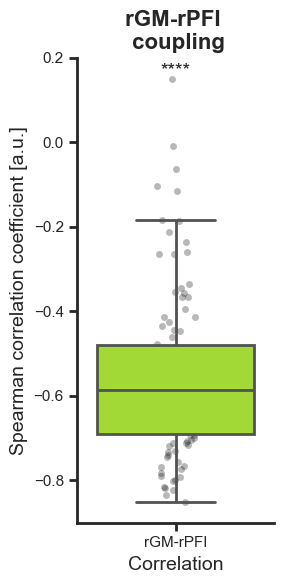

In [14]:
flicker['pair_name'] = "rGM-rPFI"

fig = plt.figure(figsize=(3, 6))


ax = sns.stripplot(data=flicker, x="pair_name", y="r_posterior_occipital_gm",color='black', dodge=True, alpha=0.28, zorder = 0)#(102/255, 217/255, 239/255), 0.9764705882352941, 0.14901960784313725, 0.4470588235294118
stripplot = sns.boxplot(data=flicker, x="pair_name", y="r_posterior_occipital_gm",saturation=0.9, linewidth=2,flierprops=dict(marker='o', markersize=3), color=(166/255, 226/255, 46/255), showfliers=False)#, medianprops={'color':(102/255, 217/255, 239/255)})

mean_val = flicker['r_posterior_occipital_gm'].mean()
std_val = flicker['r_posterior_occipital_gm'].std()

print(f"Mean: {mean_val:.3f}, Standard Deviation: {std_val:.3f}")



ax.tick_params(axis='x', which='both', direction='out', width=2)  # Adjust the width as needed
ax.tick_params(axis='y', which='both', direction='out', width=2)  # Adjust the width as needed
plt.title(f'rGM-rPFI \n coupling',fontsize = 16, weight = 'bold')
plt.xlabel('Correlation', fontsize = 14)
plt.ylabel('Spearman correlation coefficient [a.u.]', fontsize = 14)
plt.tight_layout()
sns.despine()  # Adjust spines
#ax.set_xticks([])  # Remove x-axis ticks




# statistic whether it is different to zero
data = flicker['r_posterior_occipital_gm']
#print(data)

# Perform the one-sample t-test
t_statistic, p_value = stats.ttest_1samp(data, 0, nan_policy='omit')

# Print the results
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Annotate the plot with the t-test result
# Format p-value
if p_value < 0.0001:
    p_str = '****'
else:
    p_str = f'p = {p_value:.3f}'

# Add the calculated p-value as custom text on the plot
plt.text(0.5, 0.97, f"{p_str}", ha='center', va='center', transform=ax.transAxes, fontsize=14)
#test_results = add_stat_annotation(ax, data=flicker, x="pair_name", y="r_ventricle_gm", box_pairs=[("pair_name", "r_ventricle_gm")], test='t-test_ind', text_format='star', loc='inside', verbose=2)

# Save the figure -------
#image_path = os.path.join(outDir, f'Flicker_boxplot_1.png')
#fig.savefig(image_path,dpi=600)
#---
#image_path_svg = os.path.join(outDir, 'Flicker_boxplot_1.svg')
#fig.savefig(image_path_svg)

# Panel 2F

                          Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          correlation_value
No. Observations:          424              Method:                      REML             
No. Groups:                19               Scale:                       0.0331           
Min. group size:           8                Log-Likelihood:              101.5447         
Max. group size:           36               Converged:                   Yes              
Mean group size:           22.3                                                           
------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                      -0.128    0.022  -5.921 0.000 -0.171 -0.086
location_name[T.Prefrontal

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


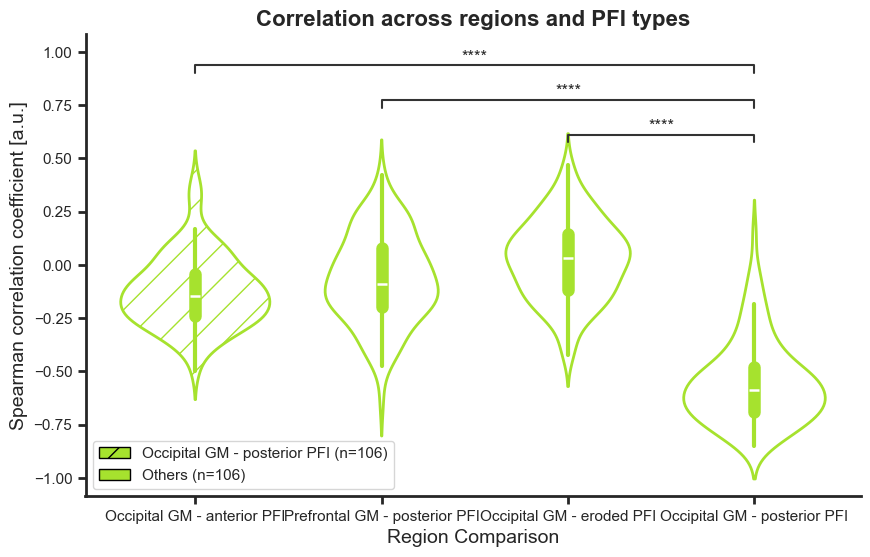

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import statsmodels.formula.api as smf
from matplotlib.patches import Patch

# Concatenate all 4 sets
flicker_correlation = pd.DataFrame()
flicker_correlation['correlation_value'] = pd.concat([
    flicker['r_anterior_occipital_gm'],
    flicker['r_posterior_frontal_gm'],
    flicker['r_eroded_ventricle_occipital_gm'],
    flicker['r_posterior_occipital_gm']], axis=0)


# Subject ID
flicker_correlation['sub_id'] = pd.concat([flicker['sub_id']] * 4, axis=0).astype(str)

# Create categorical labels
conditions = ['Occipital GM - anterior PFI', 'Prefrontal GM - posterior PFI',
              'Occipital GM - eroded PFI', 'Occipital GM - posterior PFI']
flicker_correlation['location_name'] = [cond for cond in conditions for _ in range(len(flicker))]

flicker_correlation['location_name'] = pd.Categorical(
    flicker_correlation['location_name'],
    categories=[
        'Occipital GM - anterior PFI',    
        'Prefrontal GM - posterior PFI',
        'Occipital GM - eroded PFI',
        'Occipital GM - posterior PFI'
    ],
    ordered=False
)

# Violin plot
fig = plt.figure(figsize=(10, 6))
ax = sns.violinplot(
    x="location_name", y='correlation_value', data=flicker_correlation,
    color=(166/255, 226/255, 46/255), saturation=0.9, linewidth=2, inner="box", fill=False
)
sns.despine()
ax.tick_params(axis='x', direction='out', width=2)
ax.tick_params(axis='y', direction='out', width=2)

# Add hatch pattern to first violin only
for i, violin in enumerate(ax.collections):
    if i == 0:
        violin.set_hatch('/')

# === ANOVA ===
md = smf.mixedlm("correlation_value ~ location_name", flicker_correlation, groups="sub_id")
mdf = md.fit()
print(mdf.summary())

# === Post-hoc comparisons ===
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(
    flicker_correlation['correlation_value'],
    flicker_correlation['location_name'],
    alpha=0.05
)
print(tukey)

# Extract p-values vs. reference (Occipital GM - posterior PFI)
reference = 'Occipital GM - posterior PFI'


# Grab relevant comparisons directly from Tukey output
pvals = []
comp_pairs = []

for row in tukey.summary().data[1:]:  # Skip header
    group1, group2, _, pval, _, _, _ = row
    if reference in (group1, group2):
        # Ensure reference is always first in pair
        other_group = group2 if group1 == reference else group1
        comp_pairs.append((reference, other_group))
        
        # Format p-value
        if pval <= 1e-4:
            formatted_pvalue = '****'
        elif pval <= 1e-3:
            formatted_pvalue = '***'
        elif pval <= 1e-2:
            formatted_pvalue = '**'
        elif pval <= 5e-2:
            formatted_pvalue = '*'
        else:
            formatted_pvalue = 'ns'
        pvals.append(formatted_pvalue)


# Annotate
plotting_parameters = {
    'data':    flicker_correlation,
    'x':       'location_name',
    'y':       'correlation_value',
}

annotator = Annotator(ax, comp_pairs, **plotting_parameters)
annotator.set_custom_annotations(pvals)
annotator.annotate()

# Final touches
plt.title('Correlation across regions and PFI types', fontsize=16, weight='bold')
plt.xlabel('Region Comparison', fontsize=14)
plt.ylabel('Spearman correlation coefficient [a.u.]', fontsize=14)

# Legend
legend_patches = [
    Patch(facecolor=(166/255, 226/255, 46/255), edgecolor='black', hatch='/', label=f'{reference} (n={len(flicker)})'),
    Patch(facecolor=(166/255, 226/255, 46/255), edgecolor='black', label='Others (n={})'.format(len(flicker)))
]
ax.legend(handles=legend_patches, loc='lower left')

# Save the figure -------
#image_path = os.path.join(outDir, 'All_PFI_to_GM_Correlations.png')
#fig.savefig(image_path, dpi=600)

#image_path_svg = os.path.join(outDir, 'All_PFI_to_GM_Correlations.svg')
#fig.savefig(image_path_svg)
